In [36]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

**1. Load and Explore the Fashion MNIST Dataset:**

In [2]:
# Load and Explore the Fashion MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Dataset Overview

In [3]:
# Checking the shape of the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


- Training Images Shape: (60000, 28, 28)
This means there are 60,000 training images, and each image has a resolution of 28x28 pixels.

- Training Labels Shape: (60000,)
There are 60,000 labels corresponding to the training images, each representing one of the 10 classes.

- Test Images Shape: (10000, 28, 28)
There are 10,000 test images, each also with a resolution of 28x28 pixels.

- Test Labels Shape: (10000,)
There are 10,000 labels corresponding to the test images, representing the classes for the test data.

In [4]:
# Finding out the unique classes in the dataset
unique_classes = np.unique(train_labels)
print("Unique class labels:", unique_classes)

Unique class labels: [0 1 2 3 4 5 6 7 8 9]


The dataset contains 10 different classes of clothing items, each represented by an integer label (from 0 to 9). These labels correspond to:

- 0 = T-shirt/top
- 1 = Trouser
- 2 = Pullover
- 3 = Dress
- 4 = Coat
- 5 = Sandal
- 6 = Shirt
- 7 = Sneaker
- 8 = Bag
- 9 = Ankle boot

In [5]:
# Class names in the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**2. Visualizations - Exploratory Data Analysis:**

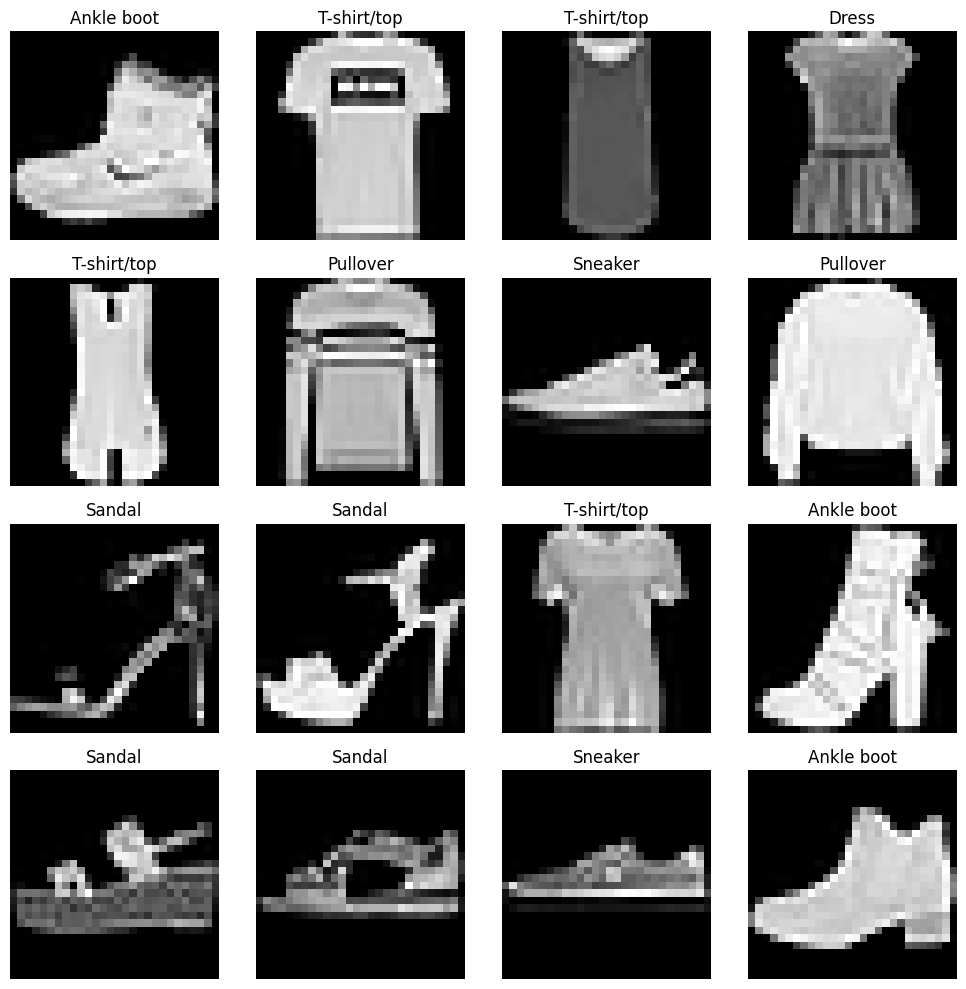

In [6]:
# Displaying some sample images from the dataset
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

<ipython-input-7-9ad15e59078c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=unique, y=counts, palette='pastel', dodge=False)


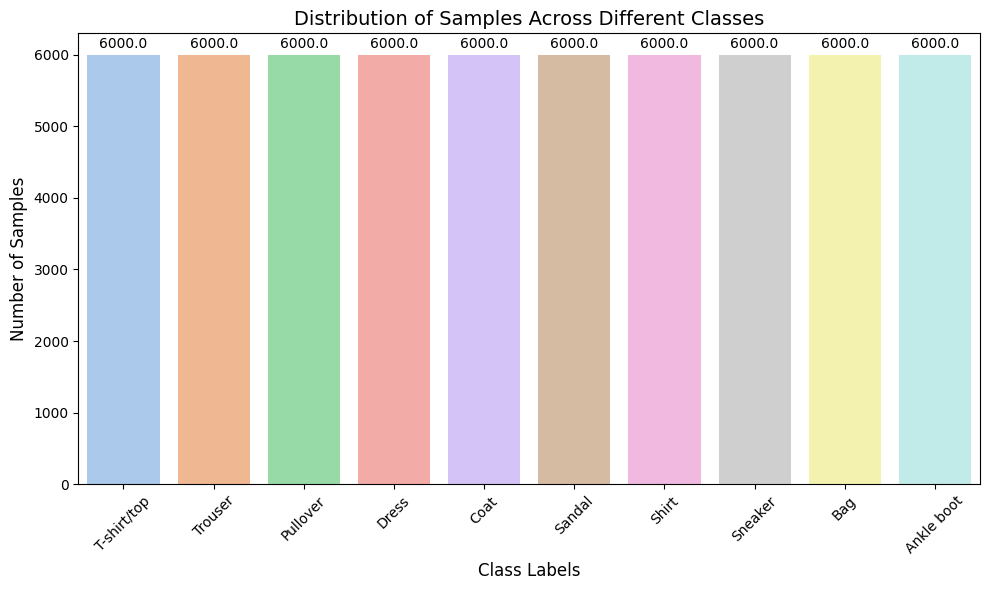

In [7]:
# Visualizing distribution of classes
unique, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=unique, y=counts, palette='pastel', dodge=False)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Samples Across Different Classes', fontsize=14)
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

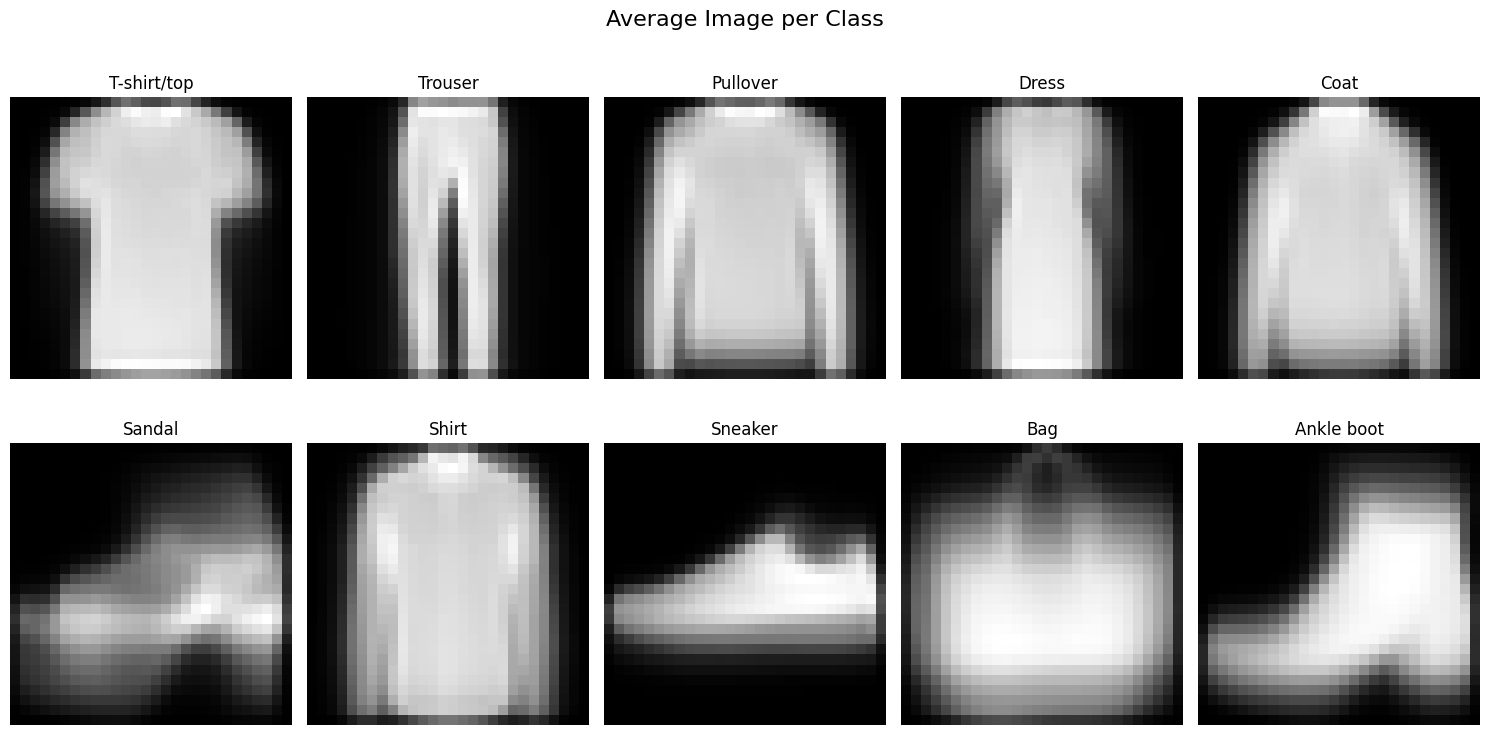

In [8]:
# Visualizing the average image per class
plt.figure(figsize=(15, 8))
for i in range(10):
    avg_image = train_images[train_labels == i].mean(axis=0)
    plt.subplot(2, 5, i + 1)
    plt.imshow(avg_image.reshape(28, 28), cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Average Image per Class', fontsize=16)
plt.tight_layout()
plt.show()

**3. Data Preprocessing:**

In [9]:
# Normalizing the image data to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

Scaling or normalizing the data is important because:

- Consistency: Neural networks perform better when the input features are on a similar scale. Normalizing the pixel values helps maintain consistency and prevents certain features from dominating due to larger scales.

- Improved Model Performance: Scaling pixel values to the range [0, 1] makes the optimization process more efficient and stable, leading to faster convergence during training.

- Avoiding Vanishing Gradients: Normalized values help in avoiding the vanishing gradient problem, especially when using activation functions like sigmoid or tanh, which are sensitive to large input values.

In [10]:
# Reshaping the data to be compatible with the ANN input format
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

Initially, the images are in a shape of (28, 28) representing their height and width. We are changing the shape from (28, 28) to (784,), where 784 is the total number of pixels (28 * 28). This transformation converts each image from a 2D matrix into a 1D vector. **Neural networks, particularly fully connected layers, expect a flat vector input rather than a 2D matrix, which is why this reshaping is necessary.**

In [11]:
# Convert labels to one-hot encoded vectors
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

One-hot encoding is important because:

- Categorical Representation: The labels in the Fashion MNIST dataset are originally integers ranging from 0 to 9, representing each class. **Neural networks typically do not work well with integer labels directly, so they need to be converted into a categorical format.**

- Binary Vectors: One-hot encoding transforms each label into a binary vector of length 10 (since there are 10 classes). Each vector contains all zeros except for a 1 at the position corresponding to the class label. For example, the label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

- Compatibility with Softmax: The last layer of the ANN uses a softmax activation function, which outputs a probability distribution over all classes. The one-hot encoded labels allow the model to calculate the categorical cross-entropy loss effectively, as it directly compares the output probability vector with the one-hot encoded true label.

- Balanced Distribution: The number of samples for each class is roughly equal, with each class having around 6,000 samples. This indicates that the dataset is well-balanced, which is beneficial for training a machine learning model. A balanced dataset helps to prevent bias towards any particular class, improving the overall performance and fairness of the model.

- Uniform Representation: Since there is no significant difference in the count of samples between classes, the model has the opportunity to learn features from all classes equally. This ensures that the model is not overfitting or underfitting any specific class due to class imbalance.

**4. Build an Artificial Neural Network:**

In [12]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

In [21]:
# Build an Artificial Neural Network
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))  # Change input shape to match the new 4D shape
model.add(Dense(512, activation='relu'))  # Increased number of neurons
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Reduced dropout rate
model.add(Dense(256, activation='relu'))  # Added more layers
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Reduced dropout rate
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Reduced dropout rate
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dense(10, activation='softmax'))

- Increase Model Complexity: Add more layers or increase the number of neurons in existing layers. This will allow the model to learn more complex features.
- Use Batch Normalization: Add batch normalization layers to improve training stability and speed up convergence.
- Added dropout layers to the neural network to help prevent overfitting.

**5. Compile the Model:**

In [24]:
# Compile the Model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 15:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

Purpose:

- Gradually decreasing the learning rate helps the model converge more effectively and can improve performance by fine-tuning the model at later epochs.
- A higher initial learning rate allows the model to learn quickly, while a lower learning rate later helps in stabilizing the training process and preventing overshooting.

In [27]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

- monitor='val_loss': It tracks the validation loss to determine when to stop training.
- patience=5: This means the training will continue for 5 more epochs after the validation loss stops improving. If there is no further improvement within this patience period, training stops.
- restore_best_weights=True: After training stops, the model's weights will be restored to the point where the validation loss was lowest, which helps to ensure the best possible model.

**6. Train the Model:**

In [28]:
# Train the Model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    validation_data=datagen.flow(test_images, test_labels, batch_size=64),
                    epochs=40,
                    callbacks=[lr_callback, early_stopping],
                    verbose=1)

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.6231 - loss: 1.0367 - val_accuracy: 0.7503 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.7352 - loss: 0.7140 - val_accuracy: 0.7556 - val_loss: 0.6311 - learning_rate: 0.0010
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.7511 - loss: 0.6636 - val_accuracy: 0.7670 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.7657 - loss: 0.6307 - val_accuracy: 0.7728 - val_loss: 0.5914 - learning_rate: 0.0010
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.7700 - loss: 0.6142 - val_accuracy: 0.7816 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.7769 - loss: 0.6034 - val_accuracy: 0.7934 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 7/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.7834 - l

Increase Training Epochs: Train the model for more epochs to allow it more time to learn.

**7. Evaluate the Model:**

In [29]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8602 - loss: 0.3863
Test Accuracy: 0.8546


- 313/313: The test set is divided into 313 batches, and the evaluation was completed for all of them.

- 1s 3ms/step: The evaluation process took around 1 second per step (i.e., per batch).

- accuracy: 0.8546: This is the accuracy on the test set during evaluation. It means that approximately 85% of the test images were classified correctly by the model.

- loss: 0.3863: This is the final value of the loss function on the test set. It measures how well the model's predictions match the true labels, with lower values indicating better performance.

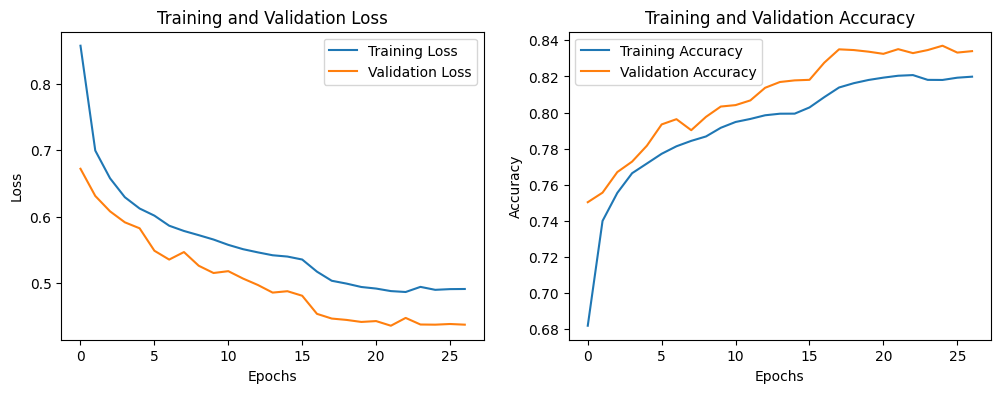

In [32]:
# Visualizing Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))
# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**Overall Analysis:**

- Good Generalization: The model seems to generalize well, as evidenced by the close proximity of the training and validation metrics.
- Underfitting Risk: The fact that the validation loss is lower than the training loss could mean that the model still has room for improvement. Potentially, the model might be slightly underfitting the training data. To address this, the model's capacity could be increased, either by adding more layers or by training for more epochs.

**8. Test Set Prediction:**

In [33]:
# Test Set Prediction
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_labels, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


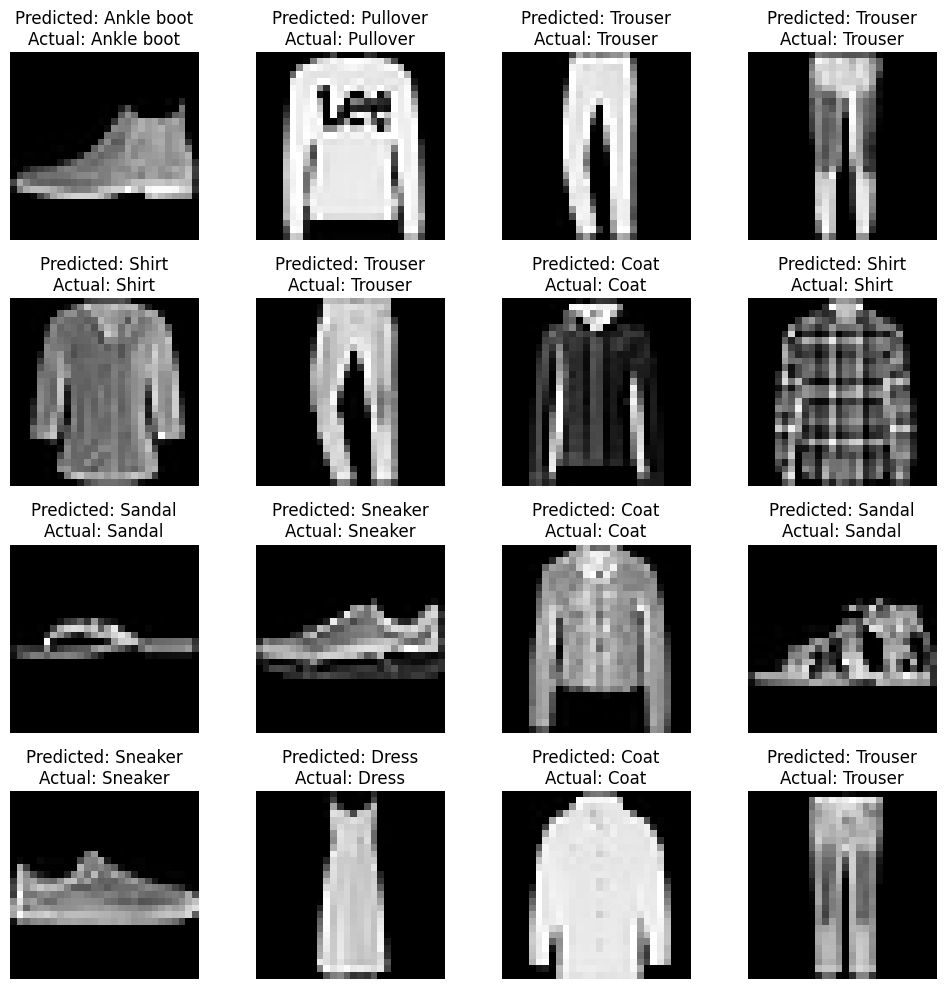

In [34]:
# Displaying sample predictions from the test set
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {class_names[predicted_classes[i]]}\nActual: {class_names[actual_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

As we can see all the sample predictions from the test set were correctly predicted

In [37]:
# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(actual_classes, predicted_classes, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.80      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.74      0.76      0.75      1000
       Dress       0.86      0.89      0.87      1000
        Coat       0.77      0.74      0.76      1000
      Sandal       0.96      0.92      0.94      1000
       Shirt       0.65      0.58      0.62      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.93      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



**Overall Accuracy:**

The model achieved an overall accuracy of 85% on the test set, which is a good result.

Class-Wise Performance:

Highest Scores:

- "Trouser" had the highest precision and recall (0.98 and 0.96), indicating that the model is very good at identifying trousers and has a low false positive and false negative rate for this class.
- "Sandal" and "Ankle boot" also showed high precision and recall, with both achieving around 94-97% in their respective metrics.

Lower Scores:

- "Shirt" had the lowest precision (0.65) and recall (0.58), indicating that it is the most challenging class for the model. The model tends to confuse shirts with other similar classes like "Pullover" and "Coat."
- "Pullover" and "Coat" also have slightly lower scores, likely due to their visual similarity with other clothing items, leading to misclassifications.

F1-Score:

- The F1-score for "Trouser" (0.97) and "Sandal" (0.94) suggests that the model is very effective for these categories.
- The F1-score for "Shirt" (0.62) indicates that the model struggles the most with this category, balancing low precision and recall.

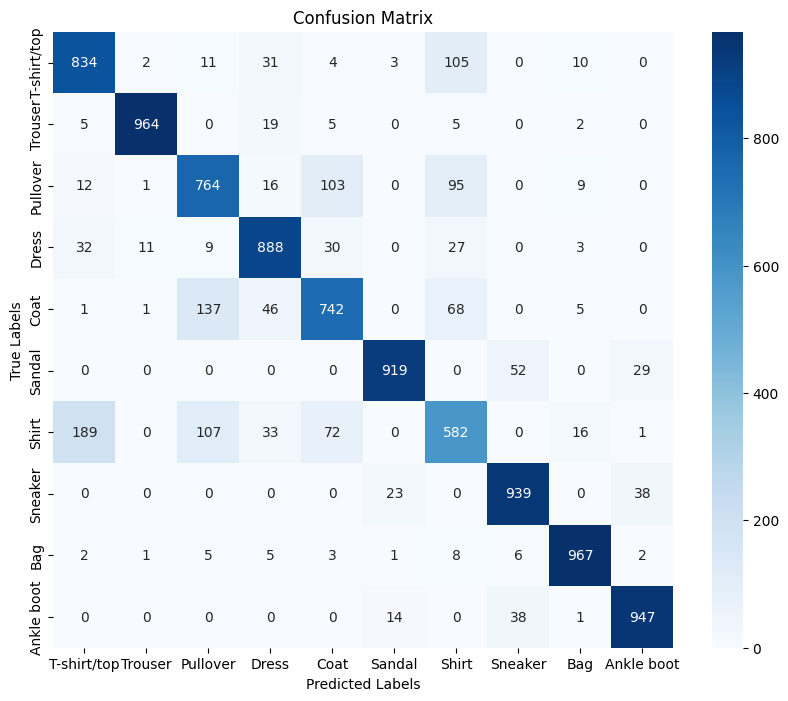

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

- The diagonal cells of the confusion matrix represent the number of correct predictions for each class.
- Classes like "Trouser," "Sandal," and "Bag" have high values along the diagonal, indicating that they are being classified accurately most of the time.

Common Misclassifications:

- "Shirt" has many misclassifications:
It is confused with "T-shirt/top" (189 instances) and "Coat" (72 instances). This suggests that the model struggles to differentiate "Shirt" from similar classes, which share similar features (e.g., sleeves, fabric).
- "Pullover" is also confused with "Coat" (103 instances) and "Shirt" (95 instances). This indicates that the model has difficulty distinguishing between similar-looking tops.
- "Coat" is misclassified as "Pullover" 137 times, indicating confusion between these two classes, likely due to similar visual patterns.